In [1]:
#Calculation_Example

In [1]:
#Loading Python Libraries
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'matplotlib'

In [3]:
#Load the projections for income and housesize

os.chdir("C:/Users/PeterRobertWalke/Documents/QGASSP/Data sources/Calculation_Data/Updated")


House_proj = pd.read_csv("House_proj_exio.csv" , index_col = 0)

Income_proj = pd.read_csv("Income_proj_exio.csv" , index_col = 0)

In [4]:
#Load the different Y vectors. 

#The user selects which one
#to use based on the urban density of the region (or the
#average one for mixed regions or if they are unsure)

os.chdir("C:/Users/PeterRobertWalke/Documents/QGASSP/Data sources/Calculation_Data/Updated/Demand_Vectors")


Y_average = pd.read_csv("Average_2020_Exio_elec_trans_en_Euro.csv", index_col = 0)
Y_city = pd.read_csv("City_2020_Exio_elec_trans_en_Euro.csv", index_col = 0)
Y_rural = pd.read_csv("Rural_2020_Exio_elec_trans_en_Euro.csv", index_col = 0)
Y_town = pd.read_csv("Town_2020_Exio_elec_trans_en_Euro.csv", index_col = 0)

In [5]:
#Load the Use phase and tail pipe emissions. 

os.chdir("C:/Users/PeterRobertWalke/Documents/QGASSP/Data sources/Calculation_Data/Updated")


Use_phase =  pd.read_csv("Energy_use_phase_Euro.csv", index_col = 0)



Tail_pipe =  pd.read_csv("Tailpipe_emissions_bp.csv", index_col = 0)

In [6]:
#Load default house sizes

House_size = pd.read_csv("Household_characteristics_2015.csv", index_col = 0)

In [7]:
#Load the Emission intesnities

os.chdir("C:/Users/PeterRobertWalke/Documents/QGASSP/Data sources/Calculation_Data/Updated/Emission_Intensities")


#M_countries is the standard Emissions factors
M_countries = pd.read_csv("Country_Emissions_intensities.csv", index_col = 0)

#M_countries_LCA is the same as M_countries, but with the electricity sector replaced with individual LCA values
#This is useful if there is local electricity production. The user can replace certain values with these values 
#if needed

M_countries_LCA = pd.read_csv("Country_Emissions_intensities_LCA.csv", index_col = 0)

products = M_countries.columns

Exio_products = pd.read_csv("Exio_products.csv")

In [8]:
#Load the IW sectors

#This is needed to put the emissions into different 'sectors', such as transport, food, building energy use, etc
os.chdir("C:/Users/PeterRobertWalke/Documents/QGASSP/Data sources/Calculation_Data/Updated")


IW_sectors = pd.read_csv("IW_sectors_reduced.csv", index_col = 0)

IW_sectors_np = IW_sectors.to_numpy()
IW_sectors_np_tr = np.transpose(IW_sectors_np)

In [9]:
#Load the adjustable amounts.

#This says how much electricity is spent on heating. There are some other things here but decided not to include.


Adjustable_amounts = pd.read_csv("adjustable_energy_amounts.csv", index_col = 0)

In [10]:
#Electricity prices database might need upstaing still

#Load the electricity prices. This is so we know in monetary terms how much is being spent on electricity. The tool
#at the moment has the electricity used by households in kWh. However, maybe this should now be changed?

Electricity_prices = pd.read_csv("electricity_prices_2019.csv", index_col = 0)

In [11]:
#Load the fuel prices at basic price
#We need this because of electric vehicles. The electricity and fuels need to be in the same units.

Fuel_prices = pd.read_csv("Fuel_prices_bp_attempt.csv", index_col = 0)

In [12]:
#Load the Income scaler. This describes how much each household spends depending on their income.

Income_scaling = pd.read_csv("mean_expenditure_by_quint.csv", index_col = 0)

In [13]:
#The different Policies are written as functions to reduce the length of the calculation code

In [14]:
def BioFuels(ab_Y, scaler):
    """        ##Explanation/Description
        This sort of policy acts only on the Expenditure (Intensities don't change)
        Similar polices could exist for houseing fuel types, ...
        Similar adjustments to this could also be needed to correct the baselines if the user knows the 
        results to be different"""
    
    ## Step 1. Determine current expenditure on fuels and the proportions of each type
    
    Total_fuel = ab_Y['Biogasoline'] + ab_Y['Biodiesels'] + ab_Y['Motor Gasoline'] + ab_Y['Gas/Diesel Oil']
        
    Diesel = (ab_Y['Biodiesels'] + ab_Y['Gas/Diesel Oil'])
        
    Petrol = (ab_Y['Motor Gasoline'] + ab_Y['Biogasoline'])
        
        #Step 2. Increase the biofuel to the designated amount
        
    ab_Y['Biogasoline'] = scaler * Total_fuel * (Petrol/ (Diesel + Petrol))
    ab_Y['Biodiesels'] =  scaler * Total_fuel * (Diesel / (Diesel + Petrol))
        
                #Step 3. Decrease the others by the correct amount, taking into account their initial values
        
        #The formula to do this is :
        #New Value = Remaining_expenditure * Old_proportion (once the previous categories are removed)
        
    Sum_changed = ab_Y['Biogasoline'] + ab_Y['Biodiesels'] #This can't be more than the total!
        
    ab_Y['Motor Gasoline'] = (Total_fuel - Sum_changed) * (Petrol / (Diesel + Petrol))
    ab_Y['Gas/Diesel Oil'] = (Total_fuel - Sum_changed) * (Diesel / (Diesel + Petrol))
    
    

In [15]:
def Electric_Vehicles(ab_Y, scaler):
    """
                 ##Policy explanation
        xx% of vehicles are ev
        First we reduce the expenditure on all forms of transport fuels by 20 %
        Then, we need to add something onto the electricity
        
        For this we need to: calculate how much fuel is saved and convert it back into Litres (and then kwh)
        Take into account the difference in efficiency between the two types
        Add the Kwh evenly onto the electricity sectors
        
        Explanation/Description
        This sort of policy acts only on the Expenditure 
        
    """

        
    
        
    #step 1 Assign a proportion of the fuels to be converted and reduce the fuels by the correct amount
        
    Diesel = (ab_Y['Biodiesels'] + ab_Y['Gas/Diesel Oil'])*scaler
        
    Petrol = (ab_Y['Motor Gasoline'] + ab_Y['Biogasoline'])*scaler
        
    Fuels = ['Biodiesels', 'Gas/Diesel Oil', 'Motor Gasoline', 'Biogasoline']
        
    for fuel in Fuels:
            
        ab_Y[fuel] = ab_Y[fuel]*(1-scaler)
                   
        
    #step 2 Turn the amount missing into kwh
        
    Diesel /= Fuel_prices.loc['Diesel_2020', country]
    Petrol /= Fuel_prices.loc['petrol_2020', country]
        
    Diesel *= 38.6*0.278   #litres, then Kwh
    Petrol *= 34.2*0.278   #litres, then kwh
        
    #step 3. #Divide that amount by 4.54 (to account foe the efficiency gains)
        
    Diesel /= 4.54         #Efficiency saving
    Petrol /=4.54          #Efficiency saving
        
    #step 4. Assign this to increased electricity demand
        
    Elec_vehicles = Diesel + Petrol      
        
    elec_total = ab_Y[electricity].sum()
        
    elec_scaler = (Elec_vehicles + elec_total) / elec_total
        
    ab_Y[electricity] *= elec_scaler
                                                        
      
        #Proportions MUST always sum to 1!!!!!!!!!!!
        

In [16]:
def Eff_improvements(ab_Y, scaler):
    """
    Policy Explanation
    Retrofitting reduces energy expenditure on heating by xx %
        
    This sort of policy acts only on the Expenditure (Intensities don't change)
    Take the expenditure on household fuels and reduce it by a scale factor defined by the user
    
    """
    
        
        #Step 1. This can be done as a single stage. 
        #Just reduce the parts that can be reduced by the amount in the scaler
            
    for liquid in liquids:
        
        ab_Y[liquid] = (ab_Y[liquid]*(1-scaler))
            
    for solid in solids:
        ab_Y[solid] = (ab_Y[solid]*(1-scaler))
        
    for gas in gases:
        ab_Y[gas] = (ab_Y[gas]*(1-scaler)) 
                                                            
    for elec in electricity:
        elec_hold = ab_Y[elec] * (1-(ad["elec_water"] +ad["elec_heat"] + ad["elec_cool"]))  #Parts not related to heating/cooling etc
        ab_Y[elec] = (ab_Y[elec]*(ad["elec_water"] +ad["elec_heat"] + ad["elec_cool"])*(1-scaler)) 
        ab_Y[elec] +=elec_hold
            
    ab_Y[district] = ab_Y[district]*(1-scaler) 
                                                                 
        #Proportions MUST always sum to 1!!!!!!!!!!!
        

In [17]:
def Transport_Modal_Shift(ab_Y,scaler, scaler_2, scaler_3):
    """
    Policy explanation
    Modal share - decrease in private transport and increase in public transport
        
    
    This sort of policy acts only on the Expenditure (Intensities don't change)
    The expenditure on private transport is reduced by a certain amount (1 part for fuels and 1 for vehicles)
    
    The public transport is also increased by a different amount. This is to account for the effects of active travel
    
    """
         
        
    Fuels = ['Biodiesels', 'Gas/Diesel Oil', 'Motor Gasoline', 'Biogasoline']
        
    for fuel in Fuels:
            
        ab_Y[fuel] *= (1-scaler)
        #In this case, we also assume that there is a reduction on the amount spent on vehicles
        #Change in modal shift takes vehicles off the road?
    Vehicles = ['Motor vehicles, trailers and semi-trailers (34)', 
                   'Sale, maintenance, repair of motor vehicles, motor vehicles parts, motorcycles, motor cycles parts and accessoiries']
        
    for vehicle in Vehicles:
            
        ab_Y[vehicle] *=(1-scaler_3)
        
        
        
    for transport in public_transport:  #Public transport was defined above
            
        ab_Y[transport] *=(1+scaler_2)
        
        #Proportions MUST always sum to 1!!!!!!!!!!!

In [18]:
def Local_generation(ab_M, ab_Y, scaler, type_electricity):
    
    """
    ##Policy explanation
        Local electricity is produced by (usually) rooftop solar and it utilised only in that area
        
        #Reduce current electricity by xx %
        #Introduce a new electricity emission intensity (based on PV in the LCA emission intensities) 
        ##that accounts for the missing xx %
        
       
    """
    
    elec_total = ab_Y[electricity].sum()
    
    for elec in electricity:
        
        ab_Y[elec] = (ab_Y[elec] * (1 - scaler))
        
    #Assign the remaning amount to the spare category (electricity nec)
    
    ab_Y['Electricity nec'] = elec_total * scaler
    
    #Set the emission intensitiy of this based on LCA values
    
    ab_M.loc[direct_ab:indirect_ab,'Electricity nec'] = M_countries_LCA.loc[direct_ab:indirect_ab,type_electricity]

In [19]:
def local_heating(ab_M, ab_Y, district_prop, elec_heat_prop, combustable_fuels_prop, liquids_prop, gas_prop, solids_prop, district_val):
    """

THIS JUST REPEATS BASELINE QUESTIONS 9 - 10.
ALLOWING THE USER TO CHANGE THE VALUES
"""

#DISTRICT HEATING
    ab_Y[district] = Total_Fuel * district_prop


#ELECTRICITY
    for elec in electricity:
    
        prop = ab_Y[elec] / elec_total #determine amount of each electricity source in total electricity mix.
        elec_hold = (1 - (ad["elec_water"] +ad["elec_heat"] + ad["elec_cool"])) * ab_Y[elec] #electricity for appliances
        ab_Y[elec] = prop * electricity_heat_prop * Total_Fuel / elec_price #Scale based on electricity use in heat and elec mix
        ab_Y[elec] += elec_hold #Add on the parts to do with appliances
    
        

    for liquid in liquids:
    
        if ab_Y[liquids].sum() != 0:
        
            prop = ab_Y[liquid] / ab_Y[liquids].sum()  #Amount of each liquid in total liquid expenditure
            ab_Y[liquid] = prop * liquids_prop * combustable_fuels_prop * Total_Fuel
        else:
        
            ab_Y['Kerosene'] = liquids_prop * combustable_fuels_prop * Total_Fuel
        

        
    for solid in solids:
    
        if ab_Y[solids].sum() != 0:
            prop = ab_Y[solid] / ab_Y[solids].sum()  #Amount of each solid in total solid expenditure
            ab_Y[solid] = prop * solids_prop * combustable_fuels_prop * Total_Fuel
    
        else:
            ab_Y['Wood and products of wood and cork (except furniture); articles of straw and plaiting materials (20)'] = solids_prop * combustable_fuels_prop * Total_Fuel

        
    for gas in gases:
    
        if ab_Y[gases].sum() != 0:
            prop = ab_Y[gas] / ab_Y[gases].sum()  #Amount of each gas in total gas expenditure
            ab_Y[gas] = prop * gases_prop * combustable_fuels_prop * Total_Fuel

        else:
            ab_Y['Distribution services of gaseous fuels through mains'] = gases_prop * combustable_fuels_prop * Total_Fuel


    #The 'direct_ab' value should be changed to the value the user wants. 
    #The user needs to convert the value into kg CO2e / Euro 
    ab_M.loc[direct_ab,district] = district_val ####1.0475#USER_INPUT
################################################################

In [20]:
"""

Construction Emissions new part. 

This answers the question on the first policy page 
"2. Construction 
2.1 New planned residential buildings in total gross square meters, m2"

"""


North = ['Denmark', 'Finland' , 'Sweden' , 'Norway' , 'Iceland']

West = ['Austria', 'Belgium', 'Germany', 'Spain', 'France' , 'Ireland', 'Italy' , 'Luxembourg' , 'Malta', 'Netherlands',
       'Portugal', 'United Kingdom', 'Switzerland' , 'Liechenstein']

East = ['Bulgaria', 'Cyprus', 'Czechia', 'Estonia', 'Greece', 'Hungary', 'Croatia', 'Lithuania', 'Latvia', 'Poland', 
       'Romania', 'Slovenia', 'Slovakia', ]

In [21]:
###LIST of Variables from here#############################################################################
#All values have defaults apart from the ones with #required. So the minimum data required by the user for the 
#baseline is filling in the required data.

#I don't know how to make it so that the default variables are loaded and can then be chanegd by the user.
#I think it would be necessary to recall the data from the server after the first consumption calculations screen.

year = int()   #required
Region = str()   #required #Equivalent to "name the project"
Policy_label = str() #I ask this to differentiate between policies, but maybe the tool has another way.
country = str()   #Required
ab =str()      #This can be combined with the one above

target_area = str() #Required #3 options in dropdown menu
U_type =str()   #Required #4_options in drop down menu - mixed, rural, city, town
pop_size = int() #Required - completely open


house_size = float() #completely open
income_level = str() # There are 5 options in a drop down menu

eff_scaling = float() #default value should be 0.97 (equivalent to 3 %)

river_prop = float()
ferry_prop = float()
rail_prop = float()
bus_prop = float()       #These values should sum to 1 (or 100 %)

hydro_prop = float()         #These are all to do with electricity mix 99% of time should use default values
solar_pvc_prop = float()
coal_prop = float()
gas_prop = float()
nuclear_prop = float()
wind_prop = float()
petrol_prop = float()
solar_thermal_prop = float()
tide_prop = float()
geo_prop = float()
nec_prop = float()           #Last electricity mix  #These values should sum to 1 (or 100 %)

district_prop = float()
electricity_heat_prop = float()
combustable_fuels_prop = float()    #These 3 values should sum to 1 (or 100 %)

liquids_prop = float()
solids_prop = float()
gases_prop = float()                #These 3 values should sum to 1 (or 100 %)

direct_district_emissions = float()

####These are all the inputs required for the baseline

###For the policies, the following additional questions are required (as well as those above)
policy_year = int()   #required#This question has been missed in the UI


Eff_gain = str()     #required
Eff_scaler = float()  

Local_electricity = str()
EL_Type = str() # 3 options from drop_down menu
EL_scaler = float()

S_heating = str() #Required

Biofuel_takeup = str() #Required
bio_scaler = float()

EV_takeup = str() #Required
EV_scaler = float()

Modal_Shift = str() #Required
MS_fuel_scaler = float()
MS_pt_scaler = float()
MS_veh_scaler = float()

New_floor_area = float() #default is zero

In [22]:
"""
A note about the different types of area (existing area, partially existing area, new area)

Existing_area:

Here the calculation works as usuaully understood. E.g. calculate the baseline and then calculate policy changes and 
compare them.

Partially existing area:

This corresponds to new developments (and new populations) within an existing area.

Here, the baseline is caculated representing the existing population.
Then, the 'policy' represents the new population. The final result 
should be a weighted sum of the two (weighted by population). And this is what is compared against the baseline

New area:

Here, there is 0 original population. So the baseline calculation should be zero before the year of the policy
(which corresponds to the year of the policy)


"""

"\nA note about the different types of area (existing area, partially existing area, new area)\n\nExisting_area:\n\nHere the calculation works as usuaully understood. E.g. calculate the baseline and then calculate policy changes and \ncompare them.\n\nPartially existing area:\n\nThis corresponds to new developments (and new populations) within an existing area.\n\nHere, the baseline is caculated representing the existing population.\nThen, the 'policy' represents the new population. The final result \nshould be a weighted sum of the two (weighted by population). And this is what is compared against the baseline\n\nNew area:\n\nHere, there is 0 original population. So the baseline calculation should be zero before the year of the policy\n(which corresponds to the year of the policy)\n\n\n"

In [23]:
#This is an example of how the calculaton should work

In [24]:
#Baseline calculation here - policies is essentially the same calcualtion
###########Explanation#######################
#The calculations work by describing the economy as being composed of 200 products, given by 'products'. 
#For each product there is an emission intensity and they are collected together in ab_M. There are seperate emission
#intensties for the 'direct production' and the 'indirect production' (rest of the supply chain). So ab_M is a 200 x 2
#table
#Some products that describe household fuel use for heat and also transport fuel use for cars have another emission 
#intesntiy as well. These are held in seperate tables 'use_phase' and 'tail_pipe' (all other products have 0 here)

#To calculate the Emissions, each value in ab_M + the values in use_phase and tail_pipe are multiplied by the amount
#the household spends on each of the 200 products. These are stored in another table caled ab_Y (demand vector)
#The emissions for each product from the direct production, indirect production, and use_phase/tail_pipe 
#to get the total emissions for that product.

#Once we have the total emissions for each product for that year, they are grouped together into 'sectors' that describe different things.
#There are 7 in total: Household Energy, Household Other, transport fuels, transport other, air transport, food, 
#tangible goods and  services

#The calculations are performed every year until 2050, with the values of ab_Y and ab_M changing slighting each year.
#This is based on 3 factors, efficiency improvements, changes in income and changes in household size. There is also a 
#section where these projections can change as a result of different policies (for the baseline no policies are introduced)

##################################################################################################################
##################################################################################################################
#Determine Emissions for all years
################Question 2##########################################
year = 2020

policy_year = 2025#USER_INPUT
##########################################
Region = "Berlin" #User_input
Policy_label = "BL"  #This is just a label for the policy
#########Question 3#########################################
country = "Germany"  #This is to choose the country - USER_INPUT
ab = "DE"            #This is to identify the country, should match above
####################################################################

#######Question 4#################################################
U_type = "city" #'average', 'town', 'city', 'rural'  #This is to select the demand vector - the user should choose
#################################################################




#Forming data for the calculations

#These are needed for holding the results
DF = pd.DataFrame(np.zeros((30,8)),index = list(range(2020,2050))
                                                      , columns = IW_sectors.columns)  #Holds final data in sectors 7 (+ sum)

DF_tot = pd.DataFrame(np.zeros((30,200)),index = list(range(2020,2050))
                                                      ,columns = products) #holds final data in products (200)

                                                      
direct_ab = "direct_"+ab
indirect_ab = "indirect_"+ab
M_countries.loc[direct_ab:indirect_ab,:].copy()
                                                      
ab_M = locals() [ab + "_M"] = M_countries.loc[direct_ab:indirect_ab,:].copy()  #Here the emission intensities                                                 
                                                                               #are selected
                                                                            
    #Extract 

ab_Y = Y_city[country].copy()  ##Here the demand vector is selected



#These are needed for the use phase emissions

Tail_pipe_ab = Tail_pipe[country].copy()

Use_phase_ab = Use_phase[country].copy()

#This is needed for calculating the amount of electricity coming from heating

ad = Adjustable_amounts[country].copy()

elec_price = Electricity_prices[country]["BP_2019_S2_Euro"] 


#Baseline Modifications go here


#############Question 5#########################################################
#House_size

House_size_ab = House_size.loc['Average_size_'+ U_type, country] #This is the default
#House_size_ab = 2.14#xx###USER_INPUT
################################################################################

############Question 6############################################################
#Population_size

pop_size = 10000 #USER_INPUT
locals() ["pop_size" + Policy_label] = pop_size
#####################################################################################



###########Question 7################################################################
#Income_scaler

Income_scaler = 1   #USER_INPUT#This is the default and should be used if the user doesn't know the income type
Elasticity = 1 


#Otherwise,  the user selects the income level of the household (they choose by quntiles)

#Income_scaler = Income_scaling.loc['1st_household',country] / Income_scaling.loc['Total_household',country] #USER_INPUT
#Elasticity = 1 # Random number for now. It should be specific to country and product

ab_Y *= Income_scaler * Elasticity
##############################################################################################

##This is the end of the mandatory questions


##Optional questions
#################################################################################################
#Here the user can modify the default values for the the demand. IF THEY DON'T WANT TO THEN SKIP THIS PART.


#########Question 8#############################################################################
    #Public Transport types

public_transport = ['Railway transportation services', 'Other land transportation services', 
                    'Sea and coastal water transportation services', 'Inland water transportation services']
    
    
Public_transport_sum = ab_Y[public_transport].sum()    ###This describes the total use of public transport
    
rail_prop = ab_Y['Railway transportation services'] / Public_transport_sum
bus_prop = ab_Y['Other land transportation services'] / Public_transport_sum
ferry_prop = ab_Y['Sea and coastal water transportation services'] / Public_transport_sum
river_prop = ab_Y['Inland water transportation services'] / Public_transport_sum
    
    
#These 'prop' values can be adjustable by the user. 
#For example, if the user thinks there should be no water based travel this can be set to 0
#but then the other values should be increased so that total proportions sum to equal to 1
    
#In such a case, the code to do this would be
    
river_prop = 0#USER_INPUT (often 0)
ferry_prop = 0#USER_INPUT (often 0)
bus_prop = bus_prop / (bus_prop + rail_prop) #USER_INPUT - code maintains the ratio between bus and rail
rail_prop = rail_prop / (bus_prop + rail_prop) #USER_INPUT - code maintains the ratio between bus and rail

ferry_prop = ferry_prop / (bus_prop + ferry_prop+ rail_prop)

#The values that should be adjusted are:

ab_Y['Railway transportation services'] = rail_prop * Public_transport_sum
ab_Y['Other land transportation services'] = bus_prop * Public_transport_sum
ab_Y['Sea and coastal water transportation services'] = ferry_prop * Public_transport_sum
ab_Y['Inland water transportation services'] = river_prop * Public_transport_sum

##############################################################################
    
#Otherwise, if there is no rail travel or river/sea travel then it should be:

#rail_prop = 0
#river_prop = 0
#ferry_prop = 0
#bus_prop = 1
       
######################################################################################################


#########Question 9##################################################################################
    #Electricity _ mix
#IT SHOULD BE SUGGESTED TO LEAVE THE DEFAULT VALUES 
#As above, the user can specify if the electricity mix is different to the country average for the BL
    
electricity = ['Electricity by coal', 'Electricity by gas','Electricity by nuclear',
                      'Electricity by hydro', 'Electricity by wind','Electricity by petroleum and other oil derivatives',
                      'Electricity by biomass and waste', 'Electricity by solar photovoltaic',
                      'Electricity by solar thermal', 'Electricity by tide, wave, ocean',
                      'Electricity by Geothermal', 'Electricity nec'] 

#No electricity goes in 'electricity nec'. This is used for local electricity production
    
elec_total = ab_Y[electricity].sum()
    
#The code works the same as above the the public transport. 
    
#e.g.
    
#hydro_prop = 0.7
#solar_pvc_prop = 0.3
#coal_prop = 0
#gas_prop = 0
#nuclear_prop = 0
#wind_prop = 0
#petrol_prop = 0
#solar_thermal_prop = 0
#tide_prop = 0
#geo_prop = 0
#nec_prop = 0

#Then the total kWh is determined from these props
#ab_Y[electricity] = 0
    
#ab_Y['Electricity by solar photovoltaic'] = solar_pvc_prop * elec_total
#ab_Y['Electricity by hydro'] = hydro_prop * elec_total
    
    
#if the user specifies the mix, then the electricity values change to the LCA values:

#for elec in electricity:
        
    #ab_M.loc[direct_ab:indirect_ab,electricity] = M_countries_LCA.loc[direct_ab:indirect_ab,electricity] 

#IT SHOULD BE SUGGESTED THAT THE USER DOES NOT ALTER THE ELECTRICITY MIX
################################################################################################################

#######Question 10#####################################################################################
    
    
    #Supply of household heating

liquids = ['Natural Gas Liquids', 'Kerosene', 'Heavy Fuel Oil', 'Other Liquid Biofuels']
solids = ['Wood and products of wood and cork (except furniture); articles of straw and plaiting materials (20)',
                  'Coke Oven Coke']
gases = ['Distribution services of gaseous fuels through mains', 'Biogas']
        
district = 'Steam and hot water supply services'
        
electricity_heat = (ad["elec_water"] +ad["elec_heat"] + ad["elec_cool"]) * elec_total * elec_price
        
Total_Fuel = ab_Y[solids].sum() + ab_Y[liquids].sum() + ab_Y[gases].sum() + ab_Y[district].sum() + electricity_heat

#We assume all 'fuels' are the same efficiency (obviously wrong, but no time to fix)
        
#########################
#PART 1 - The user selects the heating proportions from district heating, electricity and household combustion
#########################


#Default values are given by:
district_prop = ab_Y[district] / Total_Fuel

electricity_heat_prop = electricity_heat / Total_Fuel

combustable_fuels_prop = (ab_Y[solids].sum() + ab_Y[liquids].sum() + ab_Y[gases].sum()) / Total_Fuel

###THE USER CAN ALTER THESE BY::

#THESE NUMBERS NEED TO SUM TO 1
#district_prop = 0.0#district_prop#1##USER_INPUT
#electricity_heat_prop = 1.0#electricity_heat_prop##USER_INPUT
#combustable_fuels_prop = 0.0#combustable_fuels_prop##USER_INPUT

######################################
##Part 2 - Determine final values
######################################

#Then, the final values are given by:

#DISTRICT HEATING
ab_Y[district] = Total_Fuel * district_prop


#ELECTRICITY
for elec in electricity:
    
    prop = ab_Y[elec] / elec_total #determine amount of each electricity source in total electricity mix.
    elec_hold = (1 - (ad["elec_water"] +ad["elec_heat"] + ad["elec_cool"])) * ab_Y[elec] #electricity for appliances
    ab_Y[elec] = prop * electricity_heat_prop * Total_Fuel / elec_price #Scale based on electricity use in heat and elec mix
    ab_Y[elec] += elec_hold #Add on the parts to do with appliances
    
        
#COMBUSTABLE FUELS

#Here, the user can also alter the mix of the combustable fuels.

liquids_prop = ab_Y[liquids].sum()/ (ab_Y[liquids].sum() + ab_Y[solids].sum() + ab_Y[gases].sum())
solids_prop = ab_Y[solids].sum()/ (ab_Y[liquids].sum() + ab_Y[solids].sum() + ab_Y[gases].sum())
gases_prop = ab_Y[gases].sum()/ (ab_Y[liquids].sum() + ab_Y[solids].sum() + ab_Y[gases].sum())

#THE USER CAN CHANGE THESE VALUES BUT THE SUM MUST BE EQUAL TO 1!

############Question 10.1######################
#liquids_prop = 0 # #USER INPUT
#solids_prop = 0 ##USER_INPUT
#gases_prop = 1 # #USER_INPUT


#Then

for liquid in liquids:
    
    if ab_Y[liquids].sum() != 0:
        
        prop = ab_Y[liquid] / ab_Y[liquids].sum()  #Amount of each liquid in total liquid expenditure
        ab_Y[liquid] = prop * liquids_prop * combustable_fuels_prop * Total_Fuel
    else:
        
        ab_Y['Kerosene'] = liquids_prop * combustable_fuels_prop * Total_Fuel
        

        
for solid in solids:
    
    if ab_Y[solids].sum() != 0:
        prop = ab_Y[solid] / ab_Y[solids].sum()  #Amount of each solid in total solid expenditure
        ab_Y[solid] = prop * solids_prop * combustable_fuels_prop * Total_Fuel
    
    else:
        ab_Y['Wood and products of wood and cork (except furniture); articles of straw and plaiting materials (20)'] = solids_prop * combustable_fuels_prop * Total_Fuel

        
for gas in gases:
    
    if ab_Y[gases].sum() != 0:
        prop = ab_Y[gas] / ab_Y[gases].sum()  #Amount of each gas in total gas expenditure
        ab_Y[gas] = prop * gases_prop * combustable_fuels_prop * Total_Fuel

    else:
        ab_Y['Distribution services of gaseous fuels through mains'] = gases_prop * combustable_fuels_prop * Total_Fuel

######QUESTION 11###########################################
    #The 'direct_ab' value should be changed to the value the user wants. 
    #The user needs to convert the value into kg CO2e / Euro 
direct_district_emissions = ab_M.loc[direct_ab,district]#1.0475#USER_INPUT
ab_M.loc[direct_ab,district] = direct_district_emissions
################################################################


######### Question 12########################################
#This is the expected global reduction in product emissions
eff_scaling = 0.97 #USER_INPUT
##############################################################


###############################################################
#############The actual calculation starts here################
#################################################################


income_scaling = Income_proj.loc[country]    #Scale factor applied to income - unique value for each decade
house_scaling = House_proj.loc[country]      #Scale factor applied to household size - unique value for each decade

while year <= 2050:
    
    #check the policy part
    
    if year == 2020:
   
        income_mult = 1 #This is just for the year 2020
        house_mult = 1  #This is just for the year 2020
        eff_factor = 1  #This is just for the year 2020
    
    
###########Policies are from here################################################################
    if year == policy_year:
        
        ###########################################
#     NEW PART FOR THE CONSTRUCTION EMISSIONS!
#######################################################       
##Construction emissions#############################################################################################
        
##This is what the user enters for answering the construction question in the policy tab        
       
        New_floor_area = 0   #USER_INPUT
        
#    END OF PART FOR THE CONSTRUCTION EMISSIONS!    
        
###############################################################################################################
        
        #Questions should be asked in this order! Some depend on the results of others
##############Household Efficiency###################################################        
        EFF_gain = "FALSE" #USER_INPUT
        EFF_scaler = 0.5 #USER_INPUT
        
        if EFF_gain == "TRUE":
            
            Eff_improvements(ab_Y, EFF_scaler)
            
########################################################################################################################

##############Local_Electricity########################################################################################
        
        Local_electricity = "FALSE" #USER_INPUT
        EL_Type = 'Electricity by solar photovoltaic'#USER_INPUT #'Electricity by solar photovoltaic','Electricity by biomass and waste','Electricity by wind','Electricity by Geothermal'  
        EL_scaler = 0.5

        if Local_electricity == "TRUE":
            
            Local_generation(ab_M,ab_Y, EL_scaler, EL_Type)
        
#########################################################################################################################

##############Sustainable_Heating######################################################################################
        
        S_heating = "FALSE" #USER_INPUT
        district_prop = 0.25 #USER_INPUT
        Electricity_prop = 0.75 #USER_INPUT
        combustable_fuels_prop = 0.25 #USER_INPUT
        solids_prop = 0.0 #USER_INPUT
        gases_prop = 0.0 #USER_INPUT
        liquids_prop = 0.0 #USER_INPUT
        District_value = ab_M.loc[direct_ab,district].sum()# ab_M   0.0 # USER_INPUT
        
        if S_heating == "TRUE":
            
            local_heating(ab_M, ab_Y, district_prop, Electricity_prop, 
                          combustable_fuels_prop, liquids_prop, gases_prop, solids_prop, District_value)
        
            #This is just a repeat of the baseline part
        
#########################################################################################################################

###########Biofuel_in_transport########################################################################################
        Biofuel_takeup = "FALSE" #USER_INPUT
        bio_scaler = 0.5 #USER_INPUT
        
        if Biofuel_takeup == "TRUE":
            
            BioFuels(ab_Y, bio_scaler)

##########################################################################################################################

########Electric_Vehicles##################################################################################################
        EV_takeup = "FALSE" #USER_INPUT
        EV_scaler = 0.5
        
        if EV_takeup == "TRUE":
            
            Electric_Vehicles(ab_Y, EV_scaler)
        
############################################################################################################################

#########Modal_Shift#######################################################################################################
        Modal_Shift = "FALSE" #USER_INPUT
        MS_fuel_scaler = 0.5 #USER_INPUT
        MS_veh_scaler = 0.5 #USER_INPUT
        MS_pt_scaler = 0.2  #USER_INPUT
        
        if Modal_Shift == "TRUE":
            
            Transport_Modal_Shift(ab_Y, MS_fuel_scaler, MS_pt_scaler, MS_veh_scaler)
        
###########################################################################################################################            
        
    if year > 2020 and year <= 2030:
                
        income_mult = income_scaling['2020-2030']   #Select the income multiplier for this decade
        house_mult = house_scaling['2020-2030']     #Select the house multiplier for this decade
        eff_factor = eff_scaling
        
    if  year > 2030 and year <= 2040: 
        
        income_mult = income_scaling['2030-2040']   #Seclectthe income multiplier for this decade
        house_mult = house_scaling['2030-2040']     #select the house multiplier for this decade
        eff_factor = eff_scaling
        
    if year > 2040 and year <=2050:
        
        income_mult = income_scaling['2040-2050']   #Seclectthe income multiplier for this decade
        house_mult = house_scaling['2040-2050']     #select the house multiplier for this decade
        eff_factor = eff_scaling
        
        
    ab_Y *= income_mult
        
    ab_M *=eff_factor
        
    Use_phase_ab *=eff_factor
        
    Tail_pipe_ab *=eff_factor
        
        
    #Then we have to recalculate
        
        
    GWP_ab = pd.DataFrame(ab_M.to_numpy().dot(np.diag(ab_Y.to_numpy()))) # This is the basic calculation

    GWP_ab.index = ['direct' , 'indirect']

    GWP_ab.columns = products

    Use_phase_ab_GWP = ab_Y * Use_phase_ab # This adds in the household heating fuel use

    Tail_pipe_ab_GWP = ab_Y * Tail_pipe_ab # This adds in the burning of fuel for cars

    Total_use_ab = Tail_pipe_ab_GWP.fillna(0) + Use_phase_ab_GWP.fillna(0) #This puts together in the same table (200 x 1)
                                                                           #all of the other 200 products are zero
    #Put together the IO and use phase

    GWP_ab.loc['Use phase',:] = Total_use_ab
        
        
    #GWP_EE_pc = GWP_EE/House_size_EE
        
    #print(year)
    
        
        
    #GWP_EE = GWP_EE * (eff_factor) * (income_mult)
        
    GWP_ab_pc = GWP_ab / (House_size_ab * house_mult)   
    
#Put the results into sectors  
    
    DF.loc[year] =IW_sectors_np_tr.dot(GWP_ab_pc.sum().to_numpy())
    DF_tot.loc[year] = GWP_ab_pc.sum()
    
    year +=1
    
DF['Total_Emissions'] = DF.sum(axis = 1)

###########################################################################################################
#New Construction Emissions part!
#################################################################################################################
if country in North:
    
    Building_Emissions = 350 * New_floor_area/pop_size
    
if country in West:
    
    Building_Emissions = 520 * New_floor_area/pop_size

if country in East:
    
    Building_Emissions = 580 * New_floor_area/pop_size

DF.loc[policy_year, 'Total_Emissions'] += Building_Emissions


##############################################################################################################
#End of Construction Emissions part!
#############################################################################################################


#F_tot.columns = Exio_products
locals()[Region + "_Emissions_" + Policy_label] = DF
locals()[Region+ "_Emissions_tot_" + Policy_label] = DF_tot




In [25]:
"""
This is for retrofit policy
"""

'\nThis is for retrofit policy\n'

In [26]:
#Baseline calculation here - policies is essentially the same calcualtion
###########Explanation#######################
#The calculations work by describing the economy as being composed of 200 products, given by 'products'. 
#For each product there is an emission intensity and they are collected together in ab_M. There are seperate emission
#intensties for the 'direct production' and the 'indirect production' (rest of the supply chain). So ab_M is a 200 x 2
#table
#Some products that describe household fuel use for heat and also transport fuel use for cars have another emission 
#intesntiy as well. These are held in seperate tables 'use_phase' and 'tail_pipe' (all other products have 0 here)

#To calculate the Emissions, each value in ab_M + the values in use_phase and tail_pipe are multiplied by the amount
#the household spends on each of the 200 products. These are stored in another table caled ab_Y (demand vector)
#The emissions for each product from the direct production, indirect production, and use_phase/tail_pipe 
#to get the total emissions for that product.

#Once we have the total emissions for each product for that year, they are grouped together into 'sectors' that describe different things.
#There are 7 in total: Household Energy, Household Other, transport fuels, transport other, air transport, food, 
#tangible goods and  services

#The calculations are performed every year until 2050, with the values of ab_Y and ab_M changing slighting each year.
#This is based on 3 factors, efficiency improvements, changes in income and changes in household size. There is also a 
#section where these projections can change as a result of different policies (for the baseline no policies are introduced)

##################################################################################################################
##################################################################################################################
#Determine Emissions for all years
################Question 2##########################################
year = 2020

policy_year = 2025#USER_INPUT
##########################################
Region = "Berlin" #User_input
Policy_label = "RF"  #This is just a label for the policy
#########Question 3#########################################
country = "Germany"  #This is to choose the country - USER_INPUT
ab = "DE"            #This is to identify the country, should match above
####################################################################

#######Question 4#################################################
U_type = "city" #'average', 'town', 'city', 'rural'  #This is to select the demand vector - the user should choose
#################################################################




#Forming data for the calculations

#These are needed for holding the results
DF = pd.DataFrame(np.zeros((30,8)),index = list(range(2020,2050))
                                                      , columns = IW_sectors.columns)  #Holds final data in sectors 7 (+ sum)

DF_tot = pd.DataFrame(np.zeros((30,200)),index = list(range(2020,2050))
                                                      ,columns = products) #holds final data in products (200)

                                                      
direct_ab = "direct_"+ab
indirect_ab = "indirect_"+ab
M_countries.loc[direct_ab:indirect_ab,:].copy()
                                                      
ab_M = locals() [ab + "_M"] = M_countries.loc[direct_ab:indirect_ab,:].copy()  #Here the emission intensities                                                 
                                                                               #are selected
                                                                            
    #Extract 

ab_Y = Y_city[country].copy()  ##Here the demand vector is selected



#These are needed for the use phase emissions

Tail_pipe_ab = Tail_pipe[country].copy()

Use_phase_ab = Use_phase[country].copy()

#This is needed for calculating the amount of electricity coming from heating

ad = Adjustable_amounts[country].copy()

elec_price = Electricity_prices[country]["BP_2019_S2_Euro"] 


#Baseline Modifications go here


#############Question 5#########################################################
#House_size

House_size_ab = House_size.loc['Average_size_'+ U_type, country] #This is the default
#House_size_ab = 2.14#xx###USER_INPUT
################################################################################

############Question 6############################################################
#Population_size

pop_size = 10000 #USER_INPUT
#####################################################################################



###########Question 7################################################################
#Income_scaler

Income_scaler = 1   #USER_INPUT#This is the default and should be used if the user doesn't know the income type
Elasticity = 1 


#Otherwise,  the user selects the income level of the household (they choose by quntiles)

#Income_scaler = Income_scaling.loc['1st_household',country] / Income_scaling.loc['Total_household',country] #USER_INPUT
#Elasticity = 1 # Random number for now. It should be specific to country and product

ab_Y *= Income_scaler * Elasticity
##############################################################################################

##This is the end of the mandatory questions


##Optional questions
#################################################################################################
#Here the user can modify the default values for the the demand. IF THEY DON'T WANT TO THEN SKIP THIS PART.


#########Question 8#############################################################################
    #Public Transport types

public_transport = ['Railway transportation services', 'Other land transportation services', 
                    'Sea and coastal water transportation services', 'Inland water transportation services']
    
    
Public_transport_sum = ab_Y[public_transport].sum()    ###This describes the total use of public transport
    
rail_prop = ab_Y['Railway transportation services'] / Public_transport_sum
bus_prop = ab_Y['Other land transportation services'] / Public_transport_sum
ferry_prop = ab_Y['Sea and coastal water transportation services'] / Public_transport_sum
river_prop = ab_Y['Inland water transportation services'] / Public_transport_sum
    
    
#These 'prop' values can be adjustable by the user. 
#For example, if the user thinks there should be no water based travel this can be set to 0
#but then the other values should be increased so that total proportions sum to equal to 1
    
#In such a case, the code to do this would be
    
river_prop = 0#USER_INPUT (often 0)
ferry_prop = 0#USER_INPUT (often 0)
bus_prop = bus_prop / (bus_prop + rail_prop) #USER_INPUT - code maintains the ratio between bus and rail
rail_prop = rail_prop / (bus_prop + rail_prop) #USER_INPUT - code maintains the ratio between bus and rail

ferry_prop = ferry_prop / (bus_prop + ferry_prop+ rail_prop)

#The values that should be adjusted are:

ab_Y['Railway transportation services'] = rail_prop * Public_transport_sum
ab_Y['Other land transportation services'] = bus_prop * Public_transport_sum
ab_Y['Sea and coastal water transportation services'] = ferry_prop * Public_transport_sum
ab_Y['Inland water transportation services'] = river_prop * Public_transport_sum

##############################################################################
    
#Otherwise, if there is no rail travel or river/sea travel then it should be:

#rail_prop = 0
#river_prop = 0
#ferry_prop = 0
#bus_prop = 1
       
######################################################################################################


#########Question 9##################################################################################
    #Electricity _ mix
#IT SHOULD BE SUGGESTED TO LEAVE THE DEFAULT VALUES 
#As above, the user can specify if the electricity mix is different to the country average for the BL
    
electricity = ['Electricity by coal', 'Electricity by gas','Electricity by nuclear',
                      'Electricity by hydro', 'Electricity by wind','Electricity by petroleum and other oil derivatives',
                      'Electricity by biomass and waste', 'Electricity by solar photovoltaic',
                      'Electricity by solar thermal', 'Electricity by tide, wave, ocean',
                      'Electricity by Geothermal', 'Electricity nec'] 

#No electricity goes in 'electricity nec'. This is used for local electricity production
    
elec_total = ab_Y[electricity].sum()
    
#The code works the same as above the the public transport. 
    
#e.g.
    
#hydro_prop = 0.7
#solar_pvc_prop = 0.3
#coal_prop = 0
#gas_prop = 0
#nuclear_prop = 0
#wind_prop = 0
#petrol_prop = 0
#solar_thermal_prop = 0
#tide_prop = 0
#geo_prop = 0
#nec_prop = 0

#Then the total kWh is determined from these props
#ab_Y[electricity] = 0
    
#ab_Y['Electricity by solar photovoltaic'] = solar_pvc_prop * elec_total
#ab_Y['Electricity by hydro'] = hydro_prop * elec_total
    
    
#if the user specifies the mix, then the electricity values change to the LCA values:

#for elec in electricity:
        
    #ab_M.loc[direct_ab:indirect_ab,electricity] = M_countries_LCA.loc[direct_ab:indirect_ab,electricity] 

#IT SHOULD BE SUGGESTED THAT THE USER DOES NOT ALTER THE ELECTRICITY MIX
################################################################################################################

#######Question 10#####################################################################################
    
    
    #Supply of household heating

liquids = ['Natural Gas Liquids', 'Kerosene', 'Heavy Fuel Oil', 'Other Liquid Biofuels']
solids = ['Wood and products of wood and cork (except furniture); articles of straw and plaiting materials (20)',
                  'Coke Oven Coke']
gases = ['Distribution services of gaseous fuels through mains', 'Biogas']
        
district = 'Steam and hot water supply services'
        
electricity_heat = (ad["elec_water"] +ad["elec_heat"] + ad["elec_cool"]) * elec_total * elec_price
        
Total_Fuel = ab_Y[solids].sum() + ab_Y[liquids].sum() + ab_Y[gases].sum() + ab_Y[district].sum() + electricity_heat

#We assume all 'fuels' are the same efficiency (obviously wrong, but no time to fix)
        
#########################
#PART 1 - The user selects the heating proportions from district heating, electricity and household combustion
#########################


#Default values are given by:
district_prop = ab_Y[district] / Total_Fuel

electricity_heat_prop = electricity_heat / Total_Fuel

combustable_fuels_prop = (ab_Y[solids].sum() + ab_Y[liquids].sum() + ab_Y[gases].sum()) / Total_Fuel

###THE USER CAN ALTER THESE BY::

#THESE NUMBERS NEED TO SUM TO 1
#district_prop = 0.0#district_prop#1##USER_INPUT
#electricity_heat_prop = 1.0#electricity_heat_prop##USER_INPUT
#combustable_fuels_prop = 0.0#combustable_fuels_prop##USER_INPUT

######################################
##Part 2 - Determine final values
######################################

#Then, the final values are given by:

#DISTRICT HEATING
ab_Y[district] = Total_Fuel * district_prop


#ELECTRICITY
for elec in electricity:
    
    prop = ab_Y[elec] / elec_total #determine amount of each electricity source in total electricity mix.
    elec_hold = (1 - (ad["elec_water"] +ad["elec_heat"] + ad["elec_cool"])) * ab_Y[elec] #electricity for appliances
    ab_Y[elec] = prop * electricity_heat_prop * Total_Fuel / elec_price #Scale based on electricity use in heat and elec mix
    ab_Y[elec] += elec_hold #Add on the parts to do with appliances
    
        
#COMBUSTABLE FUELS

#Here, the user can also alter the mix of the combustable fuels.

liquids_prop = ab_Y[liquids].sum()/ (ab_Y[liquids].sum() + ab_Y[solids].sum() + ab_Y[gases].sum())
solids_prop = ab_Y[solids].sum()/ (ab_Y[liquids].sum() + ab_Y[solids].sum() + ab_Y[gases].sum())
gases_prop = ab_Y[gases].sum()/ (ab_Y[liquids].sum() + ab_Y[solids].sum() + ab_Y[gases].sum())

#THE USER CAN CHANGE THESE VALUES BUT THE SUM MUST BE EQUAL TO 1!

############Question 10.1######################
#liquids_prop = 0 # #USER INPUT
#solids_prop = 0 ##USER_INPUT
#gases_prop = 1 # #USER_INPUT


#Then

for liquid in liquids:
    
    if ab_Y[liquids].sum() != 0:
        
        prop = ab_Y[liquid] / ab_Y[liquids].sum()  #Amount of each liquid in total liquid expenditure
        ab_Y[liquid] = prop * liquids_prop * combustable_fuels_prop * Total_Fuel
    else:
        
        ab_Y['Kerosene'] = liquids_prop * combustable_fuels_prop * Total_Fuel
        

        
for solid in solids:
    
    if ab_Y[solids].sum() != 0:
        prop = ab_Y[solid] / ab_Y[solids].sum()  #Amount of each solid in total solid expenditure
        ab_Y[solid] = prop * solids_prop * combustable_fuels_prop * Total_Fuel
    
    else:
        ab_Y['Wood and products of wood and cork (except furniture); articles of straw and plaiting materials (20)'] = solids_prop * combustable_fuels_prop * Total_Fuel

        
for gas in gases:
    
    if ab_Y[gases].sum() != 0:
        prop = ab_Y[gas] / ab_Y[gases].sum()  #Amount of each gas in total gas expenditure
        ab_Y[gas] = prop * gases_prop * combustable_fuels_prop * Total_Fuel

    else:
        ab_Y['Distribution services of gaseous fuels through mains'] = gases_prop * combustable_fuels_prop * Total_Fuel

######QUESTION 11###########################################
    #The 'direct_ab' value should be changed to the value the user wants. 
    #The user needs to convert the value into kg CO2e / Euro 
#ab_M.loc[direct_ab,district] = 1.0475#USER_INPUT
################################################################


######### Question 12########################################
#This is the expected global reduction in product emissions
eff_scaling = 0.97 #USER_INPUT
##############################################################


###############################################################
#############The actual calculation starts here################
#################################################################


income_scaling = Income_proj.loc[country]    #Scale factor applied to income - unique value for each decade
house_scaling = House_proj.loc[country]      #Scale factor applied to household size - unique value for each decade

while year <= 2050:
    
    #check the policy part
    
    if year == 2020:
   
        income_mult = 1 #This is just for the year 2020
        house_mult = 1  #This is just for the year 2020
        eff_factor = 1  #This is just for the year 2020
    
    
###########Policies are from here################################################################
    if year == policy_year:
        
        ###########################################
#     NEW PART FOR THE CONSTRUCTION EMISSIONS!
#######################################################       
##Construction emissions#############################################################################################
        
##This is what the user enters for answering the construction question in the policy tab        
       
        New_floor_area = 0   #USER_INPUT
        
#    END OF PART FOR THE CONSTRUCTION EMISSIONS!    
        
###############################################################################################################
        
        #Questions should be asked in this order! Some depend on the results of others
##############Household Efficiency###################################################        
        EFF_gain = "TRUE" #USER_INPUT
        EFF_scaler = 0.5 #USER_INPUT
        
        if EFF_gain == "TRUE":
            
            Eff_improvements(ab_Y, EFF_scaler)
            
########################################################################################################################

##############Local_Electricity########################################################################################
        
        Local_electricity = "TRUE" #USER_INPUT
        EL_Type = 'Electricity by solar photovoltaic'#USER_INPUT #'Electricity by solar photovoltaic','Electricity by biomass and waste','Electricity by wind','Electricity by Geothermal'  
        EL_scaler = 0.5

        if Local_electricity == "TRUE":
            
            Local_generation(ab_M,ab_Y, EL_scaler, EL_Type)
        
#########################################################################################################################

##############Sustainable_Heating######################################################################################
        
        S_heating = "TRUE" #USER_INPUT
        district_prop = 0.25 #USER_INPUT
        Electricity_prop = 0.75 #USER_INPUT
        combustable_fuels_prop = 0.0 #USER_INPUT
        solids_prop = 0.0 #USER_INPUT
        gases_prop = 0.0 #USER_INPUT
        liquids_prop = 0.0 #USER_INPUT
        District_value = ab_M.loc[direct_ab,district].sum()# ab_M   0.0 # USER_INPUT
        
        if S_heating == "TRUE":
            
            local_heating(ab_M, ab_Y, district_prop, Electricity_prop, 
                          combustable_fuels_prop, liquids_prop, gases_prop, solids_prop, District_value)
        
            #This is just a repeat of the baseline part
        
#########################################################################################################################

###########Biofuel_in_transport########################################################################################
        Biofuel_takeup = "FALSE" #USER_INPUT
        bio_scaler = 0.5 #USER_INPUT
        
        if Biofuel_takeup == "TRUE":
            
            BioFuels(ab_Y, bio_scaler)

##########################################################################################################################

########Electric_Vehicles##################################################################################################
        EV_takeup = "FALSE" #USER_INPUT
        EV_scaler = 0.5
        
        if EV_takeup == "TRUE":
            
            Electric_Vehicles(ab_Y, EV_scaler)
        
############################################################################################################################

#########Modal_Shift#######################################################################################################
        Modal_Shift = "FALSE" #USER_INPUT
        MS_fuel_scaler = 0.5 #USER_INPUT
        MS_veh_scaler = 0.5 #USER_INPUT
        MS_pt_scaler = 0.2  #USER_INPUT
        
        if Modal_Shift == "TRUE":
            
            Transport_Modal_Shift(ab_Y, MS_fuel_scaler, MS_pt_scaler, MS_veh_scaler)
        
###########################################################################################################################            
        
    if year > 2020 and year <= 2030:
                
        income_mult = income_scaling['2020-2030']   #Select the income multiplier for this decade
        house_mult = house_scaling['2020-2030']     #Select the house multiplier for this decade
        eff_factor = eff_scaling
        
    if  year > 2030 and year <= 2040: 
        
        income_mult = income_scaling['2030-2040']   #Seclectthe income multiplier for this decade
        house_mult = house_scaling['2030-2040']     #select the house multiplier for this decade
        eff_factor = eff_scaling
        
    if year > 2040 and year <=2050:
        
        income_mult = income_scaling['2040-2050']   #Seclectthe income multiplier for this decade
        house_mult = house_scaling['2040-2050']     #select the house multiplier for this decade
        eff_factor = eff_scaling
        
        
    ab_Y *= income_mult
        
    ab_M *=eff_factor
        
    Use_phase_ab *=eff_factor
        
    Tail_pipe_ab *=eff_factor
        
        
    #Then we have to recalculate
        
        
    GWP_ab = pd.DataFrame(ab_M.to_numpy().dot(np.diag(ab_Y.to_numpy()))) # This is the basic calculation

    GWP_ab.index = ['direct' , 'indirect']

    GWP_ab.columns = products

    Use_phase_ab_GWP = ab_Y * Use_phase_ab # This adds in the household heating fuel use

    Tail_pipe_ab_GWP = ab_Y * Tail_pipe_ab # This adds in the burning of fuel for cars

    Total_use_ab = Tail_pipe_ab_GWP.fillna(0) + Use_phase_ab_GWP.fillna(0) #This puts together in the same table (200 x 1)
                                                                           #all of the other 200 products are zero
    #Put together the IO and use phase

    GWP_ab.loc['Use phase',:] = Total_use_ab
        
        
    #GWP_EE_pc = GWP_EE/House_size_EE
        
    #print(year)
    
        
        
    #GWP_EE = GWP_EE * (eff_factor) * (income_mult)
        
    GWP_ab_pc = GWP_ab / (House_size_ab * house_mult)   
    
#Put the results into sectors  
    
    DF.loc[year] =IW_sectors_np_tr.dot(GWP_ab_pc.sum().to_numpy())
    DF_tot.loc[year] = GWP_ab_pc.sum()
    
    year +=1
    
DF['Total_Emissions'] = DF.sum(axis = 1)

###########################################################################################################
#New Construction Emissions part!
#################################################################################################################
if country in North:
    
    Building_Emissions = 350 * New_floor_area/pop_size
    
if country in West:
    
    Building_Emissions = 520 * New_floor_area/pop_size

if country in East:
    
    Building_Emissions = 580 * New_floor_area/pop_size

DF.loc[policy_year, 'Total_Emissions'] += Building_Emissions


##############################################################################################################
#End of Construction Emissions part!
#############################################################################################################


#F_tot.columns = Exio_products
locals()[Region + "_Emissions_" + Policy_label] = DF
locals()[Region+ "_Emissions_tot_" + Policy_label] = DF_tot




In [27]:
"""
THIS is for a just an extra copy for a new area
"""
#For a new area. Start the calculation from the year of buildign completion. ALlow the policies to be open from the start
#Practically, this means setting to year of the policies to the start of the calculation

'\nTHIS is for a just an extra copy for a new area\n'

In [28]:
#Baseline calculation here
###########Explanation#######################
#The calculations work by describing the economy as being composed of 200 products, given by 'products'. 
#For each product there is an emission intensity and they are collected together in ab_M. There are seperate emission
#intensties for the 'direct production' and the 'indirect production' (rest of the supply chain). So ab_M is a 200 x 2
#table
#Some products that describe household fuel use for heat and also transport fuel use for cars have another emission 
#intesntiy as well. These are held in seperate tables 'use_phase' and 'tail_pipe' (all other products have 0 here)

#To calculate the Emissions, each value in ab_M + the values in use_phase and tail_pipe are multiplied by the amount
#the household spends on each of the 200 products. These are stored in another table caled ab_Y (demand vector)
#The emissions for each product from the direct production, indirect production, and use_phase/tail_pipe 
#to get the total emissions for that product.

#Once we have the total emissions for each product for that year, they are grouped together into 'sectors' that describe different things.
#There are 7 in total: Household Energy, Household Other, transport fuels, transport other, air transport, food, 
#tangible goods and  services

#The calculations are performed every year until 2050, with the values of ab_Y and ab_M changing slighting each year.
#This is based on 3 factors, efficiency improvements, changes in income and changes in household size. There is also a 
#section where these projections can change as a result of different policies (for the baseline no policies are introduced)

##################################################################################################################
##################################################################################################################
#Determine Emissions for all years
################Question 2##########################################
year = 2025   #SEt to year of building since there are no residents before this

policy_year = 2025#USER_INPUT
##########################################
Region = "Berlin" #User_input
Policy_label = "NA"  #This is just a label for the policy
#########Question 3#########################################
country = "Germany"  #This is to choose the country - USER_INPUT
ab = "DE"            #This is to identify the country, should match above
####################################################################

#######Question 4#################################################
U_type = "city" #'average', 'town', 'city', 'rural'  #This is to select the demand vector - the user should choose
#################################################################




#Forming data for the calculations

#These are needed for holding the results
DF = pd.DataFrame(np.zeros((30,8)),index = list(range(2020,2050))
                                                      , columns = IW_sectors.columns)  #Holds final data in sectors 7 (+ sum)

DF_tot = pd.DataFrame(np.zeros((30,200)),index = list(range(2020,2050))
                                                      ,columns = products) #holds final data in products (200)

                                                      
direct_ab = "direct_"+ab
indirect_ab = "indirect_"+ab
M_countries.loc[direct_ab:indirect_ab,:].copy()
                                                      
ab_M = locals() [ab + "_M"] = M_countries.loc[direct_ab:indirect_ab,:].copy()  #Here the emission intensities                                                 
                                                                               #are selected
                                                                            
    #Extract 

ab_Y = Y_city[country].copy()  ##Here the demand vector is selected



#These are needed for the use phase emissions

Tail_pipe_ab = Tail_pipe[country].copy()

Use_phase_ab = Use_phase[country].copy()

#This is needed for calculating the amount of electricity coming from heating

ad = Adjustable_amounts[country].copy()

elec_price = Electricity_prices[country]["BP_2019_S2_Euro"] 


#Baseline Modifications go here


#############Question 5#########################################################
#House_size

House_size_ab = House_size.loc['Average_size_'+ U_type, country] #This is the default
#House_size_ab = 2.14#xx###USER_INPUT
################################################################################

############Question 6############################################################
#Population_size

pop_size = 10000 #USER_INPUT
#####################################################################################



###########Question 7################################################################
#Income_scaler

Income_scaler = 1   #USER_INPUT#This is the default and should be used if the user doesn't know the income type
Elasticity = 1 


#Otherwise,  the user selects the income level of the household (they choose by quntiles)

#Income_scaler = Income_scaling.loc['1st_household',country] / Income_scaling.loc['Total_household',country] #USER_INPUT
#Elasticity = 1 # Random number for now. It should be specific to country and product

ab_Y *= Income_scaler * Elasticity
##############################################################################################

##This is the end of the mandatory questions


##Optional questions
#################################################################################################
#Here the user can modify the default values for the the demand. IF THEY DON'T WANT TO THEN SKIP THIS PART.


#########Question 8#############################################################################
    #Public Transport types

public_transport = ['Railway transportation services', 'Other land transportation services', 
                    'Sea and coastal water transportation services', 'Inland water transportation services']
    
    
Public_transport_sum = ab_Y[public_transport].sum()    ###This describes the total use of public transport
    
rail_prop = ab_Y['Railway transportation services'] / Public_transport_sum
bus_prop = ab_Y['Other land transportation services'] / Public_transport_sum
ferry_prop = ab_Y['Sea and coastal water transportation services'] / Public_transport_sum
river_prop = ab_Y['Inland water transportation services'] / Public_transport_sum
    
    
#These 'prop' values can be adjustable by the user. 
#For example, if the user thinks there should be no water based travel this can be set to 0
#but then the other values should be increased so that total proportions sum to equal to 1
    
#In such a case, the code to do this would be
    
river_prop = 0#USER_INPUT (often 0)
ferry_prop = 0#USER_INPUT (often 0)
bus_prop = bus_prop / (bus_prop + rail_prop) #USER_INPUT - code maintains the ratio between bus and rail
rail_prop = rail_prop / (bus_prop + rail_prop) #USER_INPUT - code maintains the ratio between bus and rail



#The values that should be adjusted are:

ab_Y['Railway transportation services'] = rail_prop * Public_transport_sum
ab_Y['Other land transportation services'] = bus_prop * Public_transport_sum
ab_Y['Sea and coastal water transportation services'] = ferry_prop * Public_transport_sum
ab_Y['Inland water transportation services'] = river_prop * Public_transport_sum

##############################################################################
    
#Otherwise, if there is no rail travel or river/sea travel then it should be:

#rail_prop = 0
#river_prop = 0
#ferry_prop = 0
#bus_prop = 1
       
######################################################################################################


#########Question 9##################################################################################
    #Electricity _ mix
#IT SHOULD BE SUGGESTED TO LEAVE THE DEFAULT VALUES 
#As above, the user can specify if the electricity mix is different to the country average for the BL
    
electricity = ['Electricity by coal', 'Electricity by gas','Electricity by nuclear',
                      'Electricity by hydro', 'Electricity by wind','Electricity by petroleum and other oil derivatives',
                      'Electricity by biomass and waste', 'Electricity by solar photovoltaic',
                      'Electricity by solar thermal', 'Electricity by tide, wave, ocean',
                      'Electricity by Geothermal', 'Electricity nec'] 

#No electricity goes in 'electricity nec'. This is used for local electricity production
    
elec_total = ab_Y[electricity].sum()
    
#The code works the same as above the the public transport. 
    
#e.g.
    
#hydro_prop = 0.7
#solar_pvc_prop = 0.3
#coal_prop = 0
#gas_prop = 0
#nuclear_prop = 0
#wind_prop = 0
#petrol_prop = 0
#solar_thermal_prop = 0
#tide_prop = 0
#geo_prop = 0
#nec_prop = 0

#Then the total kWh is determined from these props
#ab_Y[electricity] = 0
    
#ab_Y['Electricity by solar photovoltaic'] = solar_pvc_prop * elec_total
#ab_Y['Electricity by hydro'] = hydro_prop * elec_total
    
    
#if the user specifies the mix, then the electricity values change to the LCA values:

#for elec in electricity:
        
    #ab_M.loc[direct_ab:indirect_ab,electricity] = M_countries_LCA.loc[direct_ab:indirect_ab,electricity] 

#IT SHOULD BE SUGGESTED THAT THE USER DOES NOT ALTER THE ELECTRICITY MIX
################################################################################################################

#######Question 10#####################################################################################
    
    
    #Supply of household heating

liquids = ['Natural Gas Liquids', 'Kerosene', 'Heavy Fuel Oil', 'Other Liquid Biofuels']
solids = ['Wood and products of wood and cork (except furniture); articles of straw and plaiting materials (20)',
                  'Coke Oven Coke']
gases = ['Distribution services of gaseous fuels through mains', 'Biogas']
        
district = 'Steam and hot water supply services'
        
electricity_heat = (ad["elec_water"] +ad["elec_heat"] + ad["elec_cool"]) * elec_total * elec_price
        
Total_Fuel = ab_Y[solids].sum() + ab_Y[liquids].sum() + ab_Y[gases].sum() + ab_Y[district].sum() + electricity_heat

#We assume all 'fuels' are the same efficiency (obviously wrong, but no time to fix)
        
#########################
#PART 1 - The user selects the heating proportions from district heating, electricity and household combustion
#########################


#Default values are given by:
district_prop = ab_Y[district] / Total_Fuel

electricity_heat_prop = electricity_heat / Total_Fuel

combustable_fuels_prop = (ab_Y[solids].sum() + ab_Y[liquids].sum() + ab_Y[gases].sum()) / Total_Fuel

###THE USER CAN ALTER THESE BY::

#THESE NUMBERS NEED TO SUM TO 1
#district_prop = 0.0#district_prop#1##USER_INPUT
#electricity_heat_prop = 1.0#electricity_heat_prop##USER_INPUT
#combustable_fuels_prop = 0.0#combustable_fuels_prop##USER_INPUT

######################################
##Part 2 - Determine final values
######################################

#Then, the final values are given by:

#DISTRICT HEATING
ab_Y[district] = Total_Fuel * district_prop


#ELECTRICITY
for elec in electricity:
    
    prop = ab_Y[elec] / elec_total #determine amount of each electricity source in total electricity mix.
    elec_hold = (1 - (ad["elec_water"] +ad["elec_heat"] + ad["elec_cool"])) * ab_Y[elec] #electricity for appliances
    ab_Y[elec] = prop * electricity_heat_prop * Total_Fuel / elec_price #Scale based on electricity use in heat and elec mix
    ab_Y[elec] += elec_hold #Add on the parts to do with appliances
    
        
#COMBUSTABLE FUELS

#Here, the user can also alter the mix of the combustable fuels.

liquids_prop = ab_Y[liquids].sum()/ (ab_Y[liquids].sum() + ab_Y[solids].sum() + ab_Y[gases].sum())
solids_prop = ab_Y[solids].sum()/ (ab_Y[liquids].sum() + ab_Y[solids].sum() + ab_Y[gases].sum())
gases_prop = ab_Y[gases].sum()/ (ab_Y[liquids].sum() + ab_Y[solids].sum() + ab_Y[gases].sum())

#THE USER CAN CHANGE THESE VALUES BUT THE SUM MUST BE EQUAL TO 1!

############Question 10.1######################
#liquids_prop = 0 # #USER INPUT
#solids_prop = 0 ##USER_INPUT
#gases_prop = 1 # #USER_INPUT


#Then

for liquid in liquids:
    
    if ab_Y[liquids].sum() != 0:
        
        prop = ab_Y[liquid] / ab_Y[liquids].sum()  #Amount of each liquid in total liquid expenditure
        ab_Y[liquid] = prop * liquids_prop * combustable_fuels_prop * Total_Fuel
    else:
        
        ab_Y['Kerosene'] = liquids_prop * combustable_fuels_prop * Total_Fuel
        

        
for solid in solids:
    
    if ab_Y[solids].sum() != 0:
        prop = ab_Y[solid] / ab_Y[solids].sum()  #Amount of each solid in total solid expenditure
        ab_Y[solid] = prop * solids_prop * combustable_fuels_prop * Total_Fuel
    
    else:
        ab_Y['Wood and products of wood and cork (except furniture); articles of straw and plaiting materials (20)'] = solids_prop * combustable_fuels_prop * Total_Fuel

        
for gas in gases:
    
    if ab_Y[gases].sum() != 0:
        prop = ab_Y[gas] / ab_Y[gases].sum()  #Amount of each gas in total gas expenditure
        ab_Y[gas] = prop * gases_prop * combustable_fuels_prop * Total_Fuel

    else:
        ab_Y['Distribution services of gaseous fuels through mains'] = gases_prop * combustable_fuels_prop * Total_Fuel

######QUESTION 11###########################################
    #The 'direct_ab' value should be changed to the value the user wants. 
    #The user needs to convert the value into kg CO2e / Euro 
#ab_M.loc[direct_ab,district] = 1.0475#USER_INPUT
################################################################


######### Question 12########################################
#This is the expected global reduction in product emissions
eff_scaling = 0.97 #USER_INPUT
##############################################################


###############################################################
#############The actual calculation starts here################
#################################################################


income_scaling = Income_proj.loc[country]    #Scale factor applied to income - unique value for each decade
house_scaling = House_proj.loc[country]      #Scale factor applied to household size - unique value for each decade

while year <= 2050:
    
    #check the policy part
    
    if year == 2020:
   
        income_mult = 1 #This is just for the year 2020
        house_mult = 1  #This is just for the year 2020
        eff_factor = 1  #This is just for the year 2020
    
    
###########Policies are from here################################################################
    if year == policy_year:
   
        ###########################################
#     NEW PART FOR THE CONSTRUCTION EMISSIONS!
#######################################################       
##Construction emissions#############################################################################################
        
##This is what the user enters for answering the construction question in the policy tab        
##New floor area per person       
        New_floor_area = 560000   #USER_INPUT
        
#    END OF PART FOR THE CONSTRUCTION EMISSIONS!    
        
###############################################################################################################


        #Questions should be asked in this order! Some depend on the results of others
##############Household Efficiency###################################################        
        EFF_gain = "TRUE" #USER_INPUT
        EFF_scaler = 0.75 #USER_INPUT
        
        if EFF_gain == "TRUE":
            
            Eff_improvements(ab_Y, EFF_scaler)
########################################################################################################################

##############Local_Electricity########################################################################################        
        Local_electricity = "TRUE" #USER_INPUT
        EL_Type = 'Electricity by solar photovoltaic'#USER_INPUT #'Electricity by solar photovoltaic','Electricity by biomass and waste','Electricity by wind','Electricity by Geothermal'  
        EL_scaler = 0.75

        if Local_electricity == "TRUE":
            
            Local_generation(ab_M,ab_Y, EL_scaler, EL_Type)
        
#########################################################################################################################

##############Sustainable_Heating######################################################################################
        
        S_heating = "TRUE" #USER_INPUT
        district_prop = 0.25 #USER_INPUT
        Electricity_prop = 0.75 #USER_INPUT
        combustable_fuels_prop = 0.0 #USER_INPUT
        solids_prop = 0.0 #USER_INPUT
        gases_prop = 1.0 #USER_INPUT
        liquids_prop = 0.0 #USER_INPUT
        District_value = ab_M.loc[direct_ab,district].sum()# ab_M   0.0 # USER_INPUT
        
        if S_heating == "TRUE":
            
            local_heating(ab_M, ab_Y, district_prop, Electricity_prop, 
                          combustable_fuels_prop, liquids_prop, gases_prop, solids_prop, District_value)
        
            #This is just a repeat of the baseline part
        
#########################################################################################################################

###########Biofuel_in_transport########################################################################################
        Biofuel_takeup = "FALSE" #USER_INPUT
        bio_scaler = 0.5 #USER_INPUT
        
        if Biofuel_takeup == "TRUE":
            
            BioFuels(ab_Y, bio_scaler)

##########################################################################################################################

########Electric_Vehicles##################################################################################################
        EV_takeup = "FALSE" #USER_INPUT
        EV_scaler = 0.5
        
        if EV_takeup == "TRUE":
            
            Electric_Vehicles(ab_Y, EV_scaler)
        
############################################################################################################################

#########Modal_Shift#######################################################################################################
        Modal_Shift = "FALSE" #USER_INPUT
        MS_fuel_scaler = 0.5 #USER_INPUT
        MS_veh_scaler = 0.5 #USER_INPUT
        MS_pt_scaler = 0.2  #USER_INPUT
        
        if Modal_Shift == "TRUE":
            
            Transport_Modal_Shift(ab_Y, MS_fuel_scaler, MS_pt_scaler, MS_veh_scaler)
        
###########################################################################################################################            
        
    if year > 2020 and year <= 2030:
                
        income_mult = income_scaling['2020-2030']   #Select the income multiplier for this decade
        house_mult = house_scaling['2020-2030']     #Select the house multiplier for this decade
        eff_factor = eff_scaling
        
    if  year > 2030 and year <= 2040: 
        
        income_mult = income_scaling['2030-2040']   #Seclectthe income multiplier for this decade
        house_mult = house_scaling['2030-2040']     #select the house multiplier for this decade
        eff_factor = eff_scaling
        
    if year > 2040 and year <=2050:
        
        income_mult = income_scaling['2040-2050']   #Seclectthe income multiplier for this decade
        house_mult = house_scaling['2040-2050']     #select the house multiplier for this decade
        eff_factor = eff_scaling
        
        
    ab_Y *= income_mult
        
    ab_M *=eff_factor
        
    Use_phase_ab *=eff_factor
        
    Tail_pipe_ab *=eff_factor
        
        
    #Then we have to recalculate
        
        
    GWP_ab = pd.DataFrame(ab_M.to_numpy().dot(np.diag(ab_Y.to_numpy()))) # This is the basic calculation

    GWP_ab.index = ['direct' , 'indirect']

    GWP_ab.columns = products

    Use_phase_ab_GWP = ab_Y * Use_phase_ab # This adds in the household heating fuel use

    Tail_pipe_ab_GWP = ab_Y * Tail_pipe_ab # This adds in the burning of fuel for cars

    Total_use_ab = Tail_pipe_ab_GWP.fillna(0) + Use_phase_ab_GWP.fillna(0) #This puts together in the same table (200 x 1)
                                                                           #all of the other 200 products are zero
    #Put together the IO and use phase

    GWP_ab.loc['Use phase',:] = Total_use_ab
        
        
    #GWP_EE_pc = GWP_EE/House_size_EE
        
    #print(year)
    
        
        
    #GWP_EE = GWP_EE * (eff_factor) * (income_mult)
        
    GWP_ab_pc = GWP_ab / (House_size_ab * house_mult)   
    
#Put the results into sectors  
    
    DF.loc[year] =IW_sectors_np_tr.dot(GWP_ab_pc.sum().to_numpy())
    DF_tot.loc[year] = GWP_ab_pc.sum()
    
    year +=1
    
DF['Total_Emissions'] = DF.sum(axis = 1)

###########################################################################################################
#New Construction Emissions part!
#################################################################################################################
if country in North:
    
    Building_Emissions = 350 * New_floor_area/pop_size
    
if country in West:
    
    Building_Emissions = 520 * New_floor_area/pop_size

if country in East:
    
    Building_Emissions = 580 * New_floor_area/pop_size

DF.loc[policy_year, 'Total_Emissions'] += Building_Emissions


##############################################################################################################
#End of Construction Emissions part!
#############################################################################################################


#F_tot.columns = Exio_products
locals()[Region + "_Emissions_" + Policy_label] = DF
locals()[Region+ "_Emissions_tot_" + Policy_label] = DF_tot
    
    


In [29]:
#Alternatively, if it was for a partially new area, we combine the baseline and this result, weigthed by population.

#E.g.
policy_year = 2025
pop_size_new = 10000
pop_size_old = 10000
Berlin_Emissions_PN = Berlin_Emissions_BL.copy()
Berlin_Emissions_PN.loc[policy_year:2050] = ((Berlin_Emissions_NA * pop_size_new) + (Berlin_Emissions_BL * pop_size_old)) / (pop_size_new + pop_size_old)

In [30]:
Berlin_Emissions_PN

,Housing_Energy,Housing_Other,Transport_Fuels,Transport_Other,Air_travel,Food,Tangible_goods,Services,Total_Emissions
2020,6432.311746,3522.789389,1668.420377,181.438508,112.425153,809.648043,654.263059,393.857787,13775.154062
2021,6320.453845,3461.528081,1639.406546,178.283292,110.470079,795.568264,642.885424,387.008600,13535.604132
2022,6210.541153,3401.332108,1610.897267,175.182946,108.549005,781.733332,631.705647,380.278521,13300.219977
2023,6102.539842,3342.182943,1582.883763,172.136514,106.661337,768.138989,620.720285,373.665477,13068.929151
2024,5996.416674,3284.062381,1555.357415,169.143060,104.806497,754.781052,609.925960,367.167434,12841.660473
2025,4056.903657,3344.240309,1583.858148,172.242477,106.726996,768.611837,621.102386,373.895496,25587.581305
2026,3986.354102,3286.083970,1556.314855,169.247180,104.871013,755.245677,610.301415,367.393454,10835.811666
2027,3917.031405,3228.938970,1529.250539,166.303972,103.047306,742.111955,599.688274,361.004482,10647.376901
2028,3848.914228,3172.787721,1502.656872,163.411946,101.255314,729.206628,589.259695,354.726614,10462.219017
2029,3781.981610,3117.612942,1476.525669,160.570212,99.494484,716.525724,579.012468,348.557918,10280.281028


In [31]:
#Graphs are from here

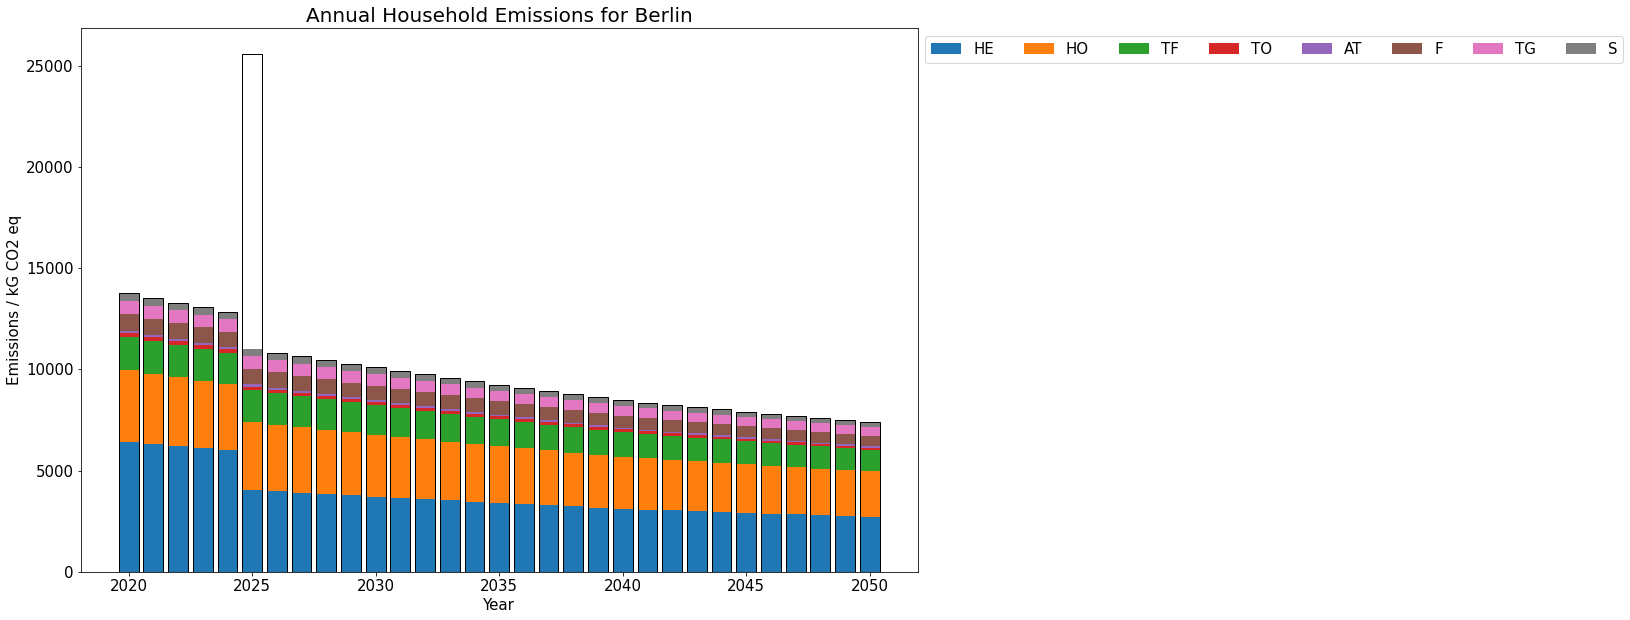

In [32]:
#First Graph is a breakdown of the Emissions as a stacked bar graph. Maybe best to just show this one by itself?

#Describe Emissions over time 
#The construction Emissions are now shown here. I just added very quickly so please make better!



fig, ax = plt.subplots(1,figsize = (15,10))
#Name of country Emissions
country = "Berlin"
Policy_label = "PN"

DF = locals()[country + "_Emissions_" + Policy_label].copy()

###
#x = np.arange(list(range(2020,2050)))
#plot bars

Labels = ['HE','HO','TF','TO','AT','F','TG','S']
sectors = list(IW_sectors.columns)

bottom = len(DF) * [0]
for idx, name in enumerate(sectors):
    plt.bar(DF.index, DF[name], bottom = bottom)
    bottom = bottom + DF[name]
 
plt.bar(DF.index, DF['Total_Emissions'], edgecolor = 'black', color = 'none')

ax.set_title("Annual Household Emissions for %s" % country, fontsize = 20)
ax.set_ylabel('Emissions / kG CO2 eq', fontsize = 15)
ax.tick_params(axis="y", labelsize=15)
ax.set_xlabel('Year', fontsize = 15)
ax.tick_params(axis="x", labelsize=15)

ax.legend(Labels, bbox_to_anchor=([1, 1, 0, 0]), ncol=8, prop={'size': 15})



plt.show()

In [33]:
#Clicking on a bar or looking at a comparison between policies should generate this second graph
#The labels below are just for dofferent policies.

#There should also be an option to remove the total emissions part (This is basically only useful for new areas)

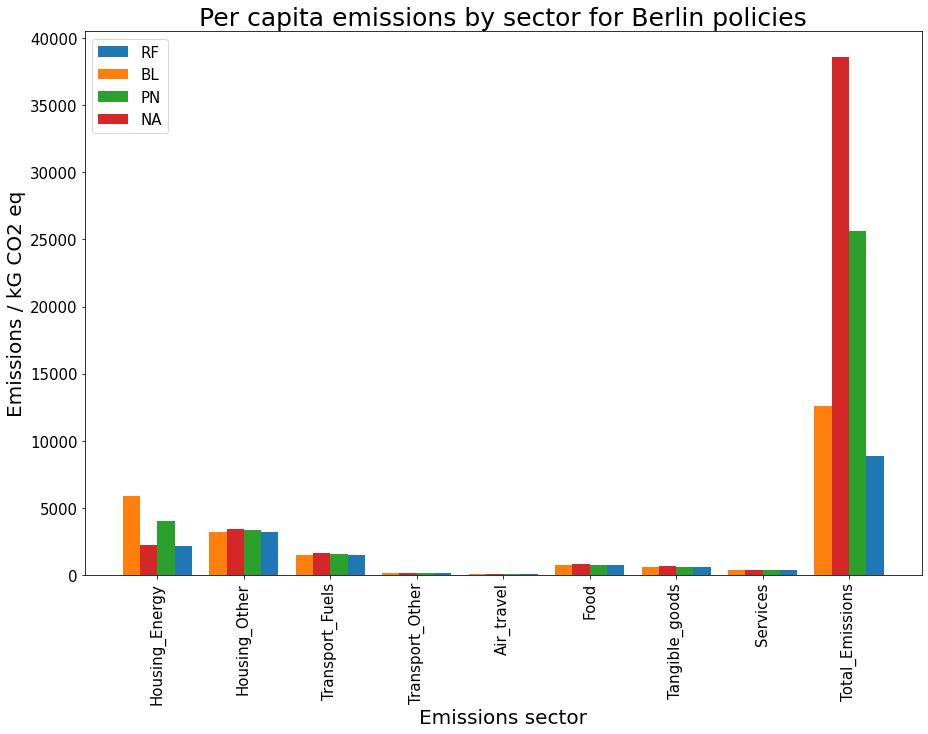

In [34]:
#Now_make_graphs_of these

#os.chdir("C:/Users/PeterRobertWalke/Documents/QGASSP/Data sources/Calculation_Data/Updated/Graphs")



width = 0.2
x = np.arange(len(Berlin_Emissions_BL.columns))

fig, ax = plt.subplots(figsize = (15,10))

rects1 = ax.bar(x + 1.5 * width, Berlin_Emissions_RF.loc[2025], width, label='RF')
rects2 = ax.bar(x - 1.5 * width, Berlin_Emissions_BL.loc[2025], width, label='BL') # Extra policies
rects3 = ax.bar(x + width / 2, Berlin_Emissions_PN.loc[2025], width, label='PN')   # Extra Policies
rects4 = ax.bar(x - width / 2, Berlin_Emissions_NA.loc[2025], width, label='NA')  # Extra Policies


#plt.bar(x_sectors, E_countries_GWP_sectors_pp['EE'], width = 0.5,  color='green')
#plt.bar(x_sectors, E_countries_GWP_sectors_pp['FI'], width = 0.5, color='blue', alpha = 0.5)
ax.legend_size = 20
ax.set_ylabel('Emissions / kG CO2 eq', fontsize = 20)
ax.set_xlabel('Emissions sector', fontsize = 20)
ax.set_title('Per capita emissions by sector for Berlin policies', fontsize = 25)
ax.set_xticks(x)
ax.set_xticklabels(Berlin_Emissions_BL.columns, fontsize = 15)
#ax.set_yticklabels( fontsize = 15)
ax.tick_params(axis="y", labelsize=15)
ax.legend(prop={'size': 15})



#x.label(rects1, padding=3)
#x.label(rects2, padding=3)                                                        
                                                        
#lt.xlabel("Sectors")
#lt.ylabel("CO2 eq /  kG?")
#lt.title("Global Emissions by Sector")

plt.xticks(x, Berlin_Emissions_BL.columns, rotation = 90)

#plt.savefig("Sectoral_Graphs_breakdown.jpg",bbox_inches='tight', dpi=300)


plt.show()


In [35]:
#Finally, there should be some sort of cumulative emissions measurement. Ths is also important in the case of delaying policies

In [36]:
#This calculates the different cumulative emissions
#Policy_labels = ["BL", "MSx50", "SHx50", "EVx50", "NA", "ALLx50_2035", "ALLx50_2025"]   #THIS is just all the policies I made 
Policy_labels = ["BL", "NA", "RF", "PN"]
#Policy_labels = ["BL", "RFx50_2025", "RFx50_2035"]#for the graphs
region = "Berlin"
for policy in Policy_labels:
    
    locals()[region + "_summed_" + policy] = pd.DataFrame(np.zeros((30,1)),index = list(range(2020,2050)), columns = ["Summed_Emissions"])

    locals()[region + "_summed_" + policy].loc[2020, "Summed_Emissions"] = locals()[region + "_Emissions_" + policy].loc[2020,'Total_Emissions']
    years = list(range(2020,2050))
    for year in years:
        locals()[region + "_summed_" + policy].loc[year+1,"Summed_Emissions"] = locals()[region + "_summed_" + policy].loc[year,"Summed_Emissions"]+ locals()[region + "_Emissions_" + policy].loc[year+1,'Total_Emissions']
        
    print("The Emissions in 2025 for %s is" % policy, locals()[region + "_Emissions_" + policy].loc[2025,'Total_Emissions'])

The Emissions in 2025 for BL is 12618.343997580578
The Emissions in 2025 for NA is 38556.818612859206
The Emissions in 2025 for RF is 8866.307399907495
The Emissions in 2025 for PN is 25587.58130521989


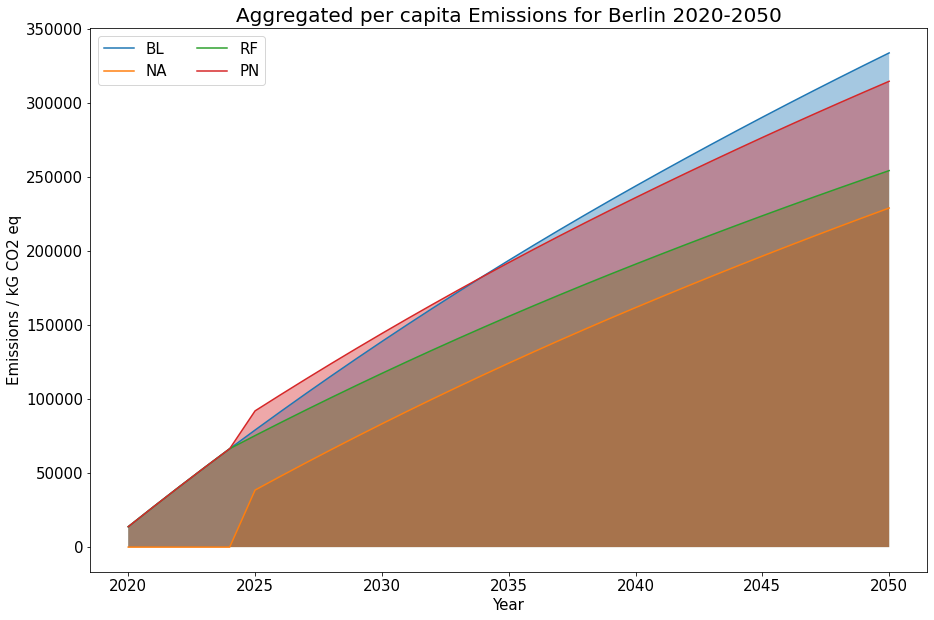

In [37]:
#Make the graph 

#Describe Emissions over time


fig, ax = plt.subplots(1,figsize = (15,10))
#Name of country Emissions
country = "Berlin"
#Policy_labels = ["BL","EVx50", "MSx50", "SHx50", "NA"]
Policy_labels = ["BL", "NA", "RF", "PN"]


counter = 0
for policy in Policy_labels:
    
    

    DF = locals()[country + "_summed_" + policy].copy()

###
#x = np.arange(list(range(2020,2050)))
#plot bars

#Labels = ['HE','HO','TF','TO','AT','F','TG','S']
    sectors = list(IW_sectors.columns)

#bottom = len(DF) * [0]
#for idx, name in enumerate(sectors):
 #   plt.bar(DF.index, DF[name], bottom = bottom)
  #  bottom = bottom + DF[name]

    plt.plot(DF.index, DF.Summed_Emissions, )
    
    plt.fill_between(DF.index, DF.Summed_Emissions,alpha = 0.4)#+counter)
    
    counter+=0.1

#x = np.arange(len(Ireland_Emissions.index))
#width = 0.8

#rects1 = ax.bar(x, Ireland_Emissions['Housing_Energy'], width, label=ab)

ax.set_title("Aggregated per capita Emissions for %s 2020-2050" % country, fontsize = 20)
ax.set_ylabel('Emissions / kG CO2 eq', fontsize = 15)
ax.tick_params(axis="y", labelsize=15)
ax.set_xlabel('Year', fontsize = 15)
ax.tick_params(axis="x", labelsize=15)

ax.legend(Policy_labels, loc='upper left' , ncol=2, prop={'size': 15})

#plt.savefig("Cumulatove_example_high_buildphase.jpg",bbox_inches='tight', dpi=300)


plt.show()

